# Define



Now that the initial hypothesis has been defined, we can focus on the following questions in the define phase:
- What matters most?
    - The cleaning and imputration of missing values in the data is essential for informing our modelling
- What is feasible?
    - What can be done that will be possible in short computation times

The number 1 goal to keep in mind in the define phase is that we are defining a product around a user, not programming a user around a product.

#### 0. Data Collection & Analysis

Data was gathered from [SEAI](https://ndber.seai.ie/BERResearchTool/ber/search.aspx) who we assume are our mortgage customers, who had a valid energy spend accounted for, as well as their mortgage property details like year of constrction etc.

The SEAI dataset can help us determine the 

This now sets up the body of work aligned with the define phase of this thesis.

Dwelling dimensions, orientation, 
ventilation, dwelling fabric, water heating, lighting, space heating, heating controls and 
fuel type influence the building energy rating and must all be considered when 
determining the actual rating and where potential improvements could be made.

In [1]:
# Read in libraries needed for analysis
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # Suppress all future warnings
pd.set_option('display.float_format', lambda x: '%.2f' % x) # Leaves all pandas calculations to 2 decimal places to avoid SN
import numpy as np
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Set a random seed so analysis is replicable
random.seed(2814)

/Users/oisinbrannock/.pyenv/versions/3.10.5/envs/masters_thesis/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Pull in the SEAI dataset to use for analysis
seai = pd.read_table( 
    '../data/external/BERPublicSearch/BERPublicsearch.txt'
    ,usecols=[  'CountyName'
              , 'DwellingTypeDescr'
              , 'Year_of_Construction'
              , 'GroundFloorArea(sq m)'
              , 'EnergyRating'
              , 'BerRating'
              , 'CO2Rating'
              , 'TotalDeliveredEnergy'
              , 'InsulationType'
              , 'InsulationThickness'
              , 'MainSpaceHeatingFuel'
              , 'MainWaterHeatingFuel'
              , 'NoOfSidesSheltered'
              , 'StructureType'
              , 'VentilationMethod']
    ,encoding = 'Latin-1'
)

/var/folders/f2/h4nbcthd4cld5t6fzd1x3jg40000gn/T/ipykernel_7219/11886991.py:2: DtypeWarning: Columns (71) have mixed types. Specify dtype option on import or set low_memory=False.
  seai = pd.read_table(


In [3]:
# High level overview of the dataset
seai

,CountyName,DwellingTypeDescr,Year_of_Construction,EnergyRating,BerRating,GroundFloorArea(sq m),CO2Rating,MainSpaceHeatingFuel,MainWaterHeatingFuel,VentilationMethod,StructureType,NoOfSidesSheltered,InsulationType,InsulationThickness,TotalDeliveredEnergy
0,Co. Donegal,Detached house,1997,C2,180.01,171.19,45.53,Heating Oil,Heating Oil,Natural vent.,Masonry,1.00,Factory Insulated,20.00,25474.52
1,Co. Kildare,Detached house,2010,B3,137.56,242.93,35.66,Heating Oil,Heating Oil,Natural vent.,Masonry,2.00,Factory Insulated,50.00,27654.47
2,Co. Dublin,Semi-detached house,1999,C3,223.61,99.38,44.65,Mains Gas,Mains Gas,Natural vent.,Masonry,3.00,Loose Jacket,20.00,17000.04
3,Dublin 11,Semi-detached house,1965,C2,196.99,138.41,37.83,Mains Gas,Mains Gas,Natural vent.,Masonry,2.00,NaN,NaN,22708.48
4,Dublin 22,Semi-detached house,1985,D2,260.52,127.16,55.07,Mains Gas,Mains Gas,Natural vent.,Masonry,2.00,Loose Jacket,100.00,28182.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1043905,Co. Donegal,Detached house,1982,D2,282.58,214.18,70.89,Heating Oil,Heating Oil,Natural vent.,Masonry,1.00,NaN,NaN,52927.53
1043906,Dublin 6,Mid-terrace house,1900,G,998.14,99.77,317.99,Manufactured Smokeless Fuel,Electricity,Natural vent.,Masonry,4.00,NaN,NaN,NaN
1043907,Dublin 1,Mid-floor apartment,2021,A2,37.26,81.32,7.33,NaN,NaN,Whole house extract vent.,Masonry,2.00,NaN,NaN,NaN
1043908,Dublin 1,Mid-floor apartment,2022,A2,36.05,82.09,6.76,NaN,NaN,Bal.whole mech.vent heat recvr,Masonry,4.00,NaN,NaN,NaN


In [4]:
# Get rid of all underscores to avoid issues later with encoding with dummy variables
seai.columns = seai.columns.str.replace('_', '')

In [5]:
# Taking a look at the SEAI dataset numerical columns
seai.describe()

,YearofConstruction,BerRating,GroundFloorArea(sq m),CO2Rating,NoOfSidesSheltered,InsulationThickness,TotalDeliveredEnergy
count,1043910.00,1043910.00,1043910.00,1043910.00,1040297.00,811123.00,445800.00
mean,1983.79,234.55,114.01,54.56,2.31,31.62,24085.64
std,33.78,172.78,59.76,48.60,1.05,23.81,23306.38
min,1753.00,-158.42,5.47,-258.25,0.00,0.00,-3929.79
25%,1973.00,153.64,77.92,32.46,2.00,25.00,14844.80
50%,1997.00,207.08,100.30,46.25,2.00,30.00,21027.03
75%,2005.00,282.32,133.71,65.13,3.00,40.00,29315.55
max,2104.00,56423.71,3546.11,18417.10,4.00,1872.00,5431169.68


In [6]:
# Check the datatypes for each column and determine if they are correct or not
seai.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1043910 entries, 0 to 1043909
Data columns (total 15 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   CountyName             1043910 non-null  object 
 1   DwellingTypeDescr      1043910 non-null  object 
 2   YearofConstruction     1043910 non-null  int64  
 3   EnergyRating           1043910 non-null  object 
 4   BerRating              1043910 non-null  float64
 5   GroundFloorArea(sq m)  1043910 non-null  float64
 6   CO2Rating              1043910 non-null  float64
 7   MainSpaceHeatingFuel   1028262 non-null  object 
 8   MainWaterHeatingFuel   1028262 non-null  object 
 9   VentilationMethod      1040297 non-null  object 
 10  StructureType          1040297 non-null  object 
 11  NoOfSidesSheltered     1040297 non-null  float64
 12  InsulationType         811123 non-null   object 
 13  InsulationThickness    811123 non-null   float64
 14  TotalDeliveredEner

In [ ]:
# Create a pandas profile report
profile = ProfileReport(seai, title="SEAI Data Report v2", explorative=True)

In [ ]:
# Output the report to a html file to view
profile.to_file("../reports/seai_profile_report_v2.html")

A few issues have arisen based on the initial observation of the data above:
- The dataset overview shows that the `CountyName` column has 'Co.' with each county and Dublin is split into numerical districts. Both need to be removed.
    - Done
- The description report shows the max year of construction is 2104. The max needs to be amended to be 2022.
    - Done
- The description report shows we have 57.3% missing values for `TotalDeliveredEnergy` column. This will need to be dropped at a minimum.
    - Done
- The description report shows that the min for `BerRating`, `CO2Rating` and `TotalDeliveredEnergy` are negative. This could be bad data or indication of a good BER rating. Needs to be investigated and dealt with.
    - Done
- The `EnergyRating` column is an object, it should be an ordered factor.
    - Done
- Change the `StructureType` value of 'Please Select' to NaN to be imputed later as this is a blank.
    - Done
- There are duplicates being accounted for on some entries that must be removed.
    - Done
- Investigate the nulls for:
    - `MainSpaceHeatingFuel`
    - `MainWaterHeatingFuel`
    - `VentilationMethod`
    - `StructureType`
    - `NoOfSidesSheltered`
    - `InsulationType`
    - `InsulationThickness`
    - `TotalDeliveredEnergy`
- The investiation should involve looking at
    - Where are the nulls?
    - Is there a commonality with other values for these nulls?
    - Is there coversely no discernible pattern?
    - Is there a structural flaw?

Note that I am not worried about the very high BerRating and CO2Rating maxiumums as they make sense when the data is examined.

### 1. Data Cleaning

#### 1.1 County Cleaning

In [7]:
# Removal of 'Co.' and numerical items from CountyName column
seai['CountyName'] = seai['CountyName'].str.replace('Co. ', '') # Removes all occurrences of Co.
seai['CountyName'] = seai['CountyName'].str.replace('City', '') # Removes all occurrences of City
seai['CountyName'] = seai['CountyName'].str.replace('\d+', '') # Removes all digits
seai['CountyName'] = seai['CountyName'].str.replace('Dublin W', 'Dublin') # Removes occurence of W after Dublin
seai['CountyName'] = seai['CountyName'].str.strip() # Removes any blankspace left after cleaning


In [8]:
# Checking out the column to see if changes have worked
print(seai['CountyName'].unique())
# Printing some lines between the two results for clarity
print('--------------------------------------------------------------------------------------------------------')
print('--------------------------------------------------------------------------------------------------------')
# Checking to see if the length is 26 (Number of counties in Republic of Ireland)
print(len(seai['CountyName'].unique()))

['Donegal' 'Kildare' 'Dublin' 'Limerick' 'Kerry' 'Kilkenny' 'Cork'
 'Wexford' 'Carlow' 'Galway' 'Louth' 'Offaly' 'Sligo' 'Wicklow' 'Clare'
 'Tipperary' 'Monaghan' 'Mayo' 'Laois' 'Westmeath' 'Roscommon' 'Meath'
 'Leitrim' 'Cavan' 'Waterford' 'Longford']
--------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------
26


In [9]:
# Convert from string to category
seai['CountyName'] = seai['CountyName'].astype('category')

---

#### 1.2 Year of Construction Cleaning

<AxesSubplot:xlabel='YearofConstruction', ylabel='Count'>

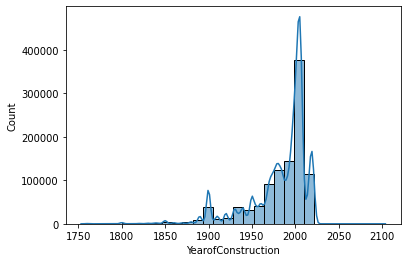

In [10]:
# Checking distribution of years of house builds
sns.histplot(data=seai
            ,x='YearofConstruction'
            ,bins=30
            ,kde=True)

We can clearly see from above 2104 as a year is a once off error and can be removed

In [11]:
# Removal of bad year entry in data
seai = seai[seai['YearofConstruction'] <= 2022]

<AxesSubplot:xlabel='YearofConstruction', ylabel='Count'>

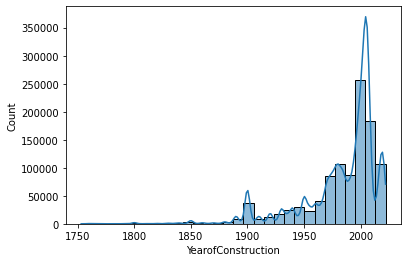

In [12]:
# Checking distributions again to check if this has worked.
sns.histplot(data=seai
            ,x='YearofConstruction'
            ,bins=30
            ,kde=True)

In [13]:
# Convert from string to category
seai['YearofConstruction'] = seai['YearofConstruction'].astype('category')

/var/folders/f2/h4nbcthd4cld5t6fzd1x3jg40000gn/T/ipykernel_7219/515895672.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seai['YearofConstruction'] = seai['YearofConstruction'].astype('category')


---

#### 1.3 CO2 Rating Cleaning

In [14]:
# Checking out the distribution of values where we have negative in the 2 columns.
seai[['EnergyRating', 'CO2Rating']][(seai[['BerRating']] < 0).all(1) | 
                                    (seai[['CO2Rating']] < 0).all(1)].groupby('EnergyRating').count()

,CO2Rating
EnergyRating,
A1,167
A2,12
A3,12
B1,8
B2,8
B3,5
C1,6
C2,4
C3,1


Interestingly we have people who have lower bounds of energy ratings but still negative CO2 emissions somehow. Perhaps these people have solar panelling but their house rating is simply just poorer. 

The majority of houses with negative emissions are A1 rated which makes sense to what I would have thought the cause to be if these values were not poor data.

I will remove any below a B2 rating as I do not see logically other than solar panelling how this would occur. Regardless these people will skew the data and as such need to be accounted for.

In [15]:
# Identify all entries that qualify for removal as above and save them to a new dataframe
seai_to_drop = seai[seai['EnergyRating'].map(lambda x: x in ['B2', 'B3', 'C1', 'C2', 'C3'])][(seai[['BerRating']] < 0).all(1) | 
                                                                                             (seai[['CO2Rating']] < 0).all(1)
                                                                                            ]
# Drop these index entries from our original dataframe
seai = seai.drop(seai_to_drop.index)
# Delete the now redundant index dataframe
del(seai_to_drop)

/var/folders/f2/h4nbcthd4cld5t6fzd1x3jg40000gn/T/ipykernel_7219/1009298007.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  seai_to_drop = seai[seai['EnergyRating'].map(lambda x: x in ['B2', 'B3', 'C1', 'C2', 'C3'])][(seai[['BerRating']] < 0).all(1) |


In [16]:
# Check to see if these entries were dropped correctly. Should produce 0 rows
seai[seai['EnergyRating'].map(lambda x: x in ['B2', 'B3', 'C1', 'C2', 'C3'])][(seai[['BerRating']] < 0).all(1) | 
                                                                              (seai[['CO2Rating']] < 0).all(1)
                                                                             ]

/var/folders/f2/h4nbcthd4cld5t6fzd1x3jg40000gn/T/ipykernel_7219/3569584113.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  seai[seai['EnergyRating'].map(lambda x: x in ['B2', 'B3', 'C1', 'C2', 'C3'])][(seai[['BerRating']] < 0).all(1) |


,CountyName,DwellingTypeDescr,YearofConstruction,EnergyRating,BerRating,GroundFloorArea(sq m),CO2Rating,MainSpaceHeatingFuel,MainWaterHeatingFuel,VentilationMethod,StructureType,NoOfSidesSheltered,InsulationType,InsulationThickness,TotalDeliveredEnergy


---

#### 1.4 Energy Rating Cleaning

In [17]:
# Remove any blank space
seai['EnergyRating'] = seai['EnergyRating'].str.strip()
# Changing the datatype of the EnergyRating column
seai['EnergyRating'] = seai['EnergyRating'].astype('category')
# Reorder categories in order of how good they are descending
seai['EnergyRating'] = seai['EnergyRating'].cat.reorder_categories(['A1', 'A2', 'A3', 'B1', 'B2', 'B3', 'C1', 'C2', 'C3', 'D1', 'D2', 'E1', 'E2', 'F', 'G'])

In [18]:
# Checking the work above is correct
seai['EnergyRating'].unique()

['C2', 'B3', 'C3', 'D2', 'D1', ..., 'B2', 'B1', 'A3', 'A2', 'A1']
Length: 15
Categories (15, object): ['A1', 'A2', 'A3', 'B1', ..., 'E1', 'E2', 'F', 'G']

<AxesSubplot:xlabel='EnergyRating', ylabel='count'>

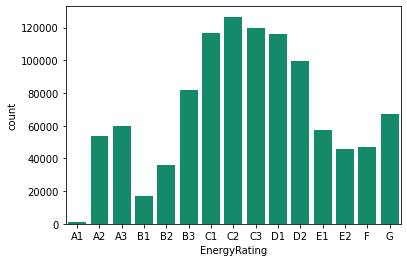

In [19]:
# Checking the distribution of BER values across the dataset
sns.countplot(
             data=seai
            ,x='EnergyRating'
            ,order=['A1', 'A2', 'A3', 'B1', 'B2', 'B3', 'C1', 'C2', 'C3', 'D1', 'D2', 'E1', 'E2', 'F', 'G']
            ,color='#009E73')

---

#### 1.5 Structure Type Cleaning

In [20]:
# Get all the unique values
seai.StructureType.unique()

array(['Masonry                       ', 'Timber or Steel Frame         ',
       'Please select                 ', 'Insulated Conctete Form       ',
       nan], dtype=object)

In [21]:
# Remove redundant 'Please Select' entry in StructureType column 
seai['StructureType'] = seai['StructureType'].replace('Please select                 ', np.nan)

# Clean the other column values
seai['StructureType'] = seai['StructureType'].replace('Masonry                       ', 'Masonry')
seai['StructureType'] = seai['StructureType'].replace('Timber or Steel Frame         ', 'Timber or Steel Frame')
seai['StructureType'] = seai['StructureType'].replace('Insulated Conctete Form       ', 'Insulated Conctete Form')

In [22]:
# Check if the above was successful
seai.StructureType.unique()

array(['Masonry', 'Timber or Steel Frame', nan, 'Insulated Conctete Form'],
      dtype=object)

---

#### 1.6 Duplicate Cleaning

In [23]:
# Drop all duplicates in the dataset and keep the first entry of each
seai = seai.drop_duplicates(keep='first')

---

#### 1.7 Dwelling Type Description Cleaning

In [24]:
# Change from a string to a category
seai['DwellingTypeDescr'] = seai['DwellingTypeDescr'].astype('category')

---


#### 1.8 Nulls analysis

##### 1.8.1 - `MainSpaceHeatingFuel`

In [25]:
# Remove any whitespace in column
seai['MainSpaceHeatingFuel'] = seai['MainSpaceHeatingFuel'].str.strip()

In [26]:
# Check out any unique values
seai['MainSpaceHeatingFuel'].unique()

array(['Heating Oil', 'Mains Gas', 'Electricity', 'Solid Multi-Fuel',
       'Sod Peat', 'Bulk LPG (propane or butane)', 'House Coal', nan,
       'Wood Logs', 'Bottled LPG', 'Peat Briquettes',
       'Wood Pellets (bulk supply for', 'Electricity - Standard Domesti',
       'Wood Pellets (in bags for seco', 'Manufactured Smokeless Fuel',
       'Anthracite', 'Wood Chips', 'Electricity - Off-peak Night-R',
       'Electricity - On-peak Night-Ra', 'Bioethanol from renewable sour',
       'Biodiesel from renewable sourc'], dtype=object)

In [27]:
# Examination of the other columns in the case where or target is null
seai[seai['MainSpaceHeatingFuel'].isna()]['MainWaterHeatingFuel'].value_counts(dropna=False)

# 14k missing
# 12k also have missing energy delivered
# Every row has water heating missing too
# Mainly missing in A rated homes - may be due no solar panel option?

# This is MNAR

NaN    14110
Name: MainWaterHeatingFuel, dtype: int64

##### 1.8.2 `MainWaterHeatingFuel`

In [28]:
# Remove any whitespace in column
seai['MainWaterHeatingFuel'] = seai['MainWaterHeatingFuel'].str.strip()

In [29]:
# Check out any unique values
seai['MainWaterHeatingFuel'].unique()

array(['Heating Oil', 'Mains Gas', 'Electricity', 'Sod Peat',
       'Solid Multi-Fuel', 'Bulk LPG (propane or butane)', 'House Coal',
       nan, 'Bottled LPG', 'Wood Logs', 'Peat Briquettes',
       'Wood Pellets (bulk supply for', 'Wood Pellets (in bags for seco',
       'Manufactured Smokeless Fuel', 'Anthracite', 'Wood Chips',
       'Bioethanol from renewable sour', 'Electricity - Standard Domesti',
       'Electricity - Off-peak Night-R', 'Electricity - On-peak Night-Ra',
       'Biodiesel from renewable sourc', 'None'], dtype=object)

In [30]:
# Examination of the other columns in the case where or target is null
seai[seai['MainWaterHeatingFuel'].isna()]['EnergyRating'].value_counts(dropna=False)

# Same 12k missing from before
# Other heating column also missing everywhere this feature is
# Same distribution of BER ratings as before

# This feature is MNAR

A2    3620
A3    2634
B3    1120
B2     924
C1     851
G      814
C2     693
D1     669
C3     658
B1     584
D2     487
F      424
E1     319
E2     309
A1       4
Name: EnergyRating, dtype: int64

##### 1.8.3 `VentilationMethod`

In [31]:
# Remove any whitespace in column
seai['VentilationMethod'] = seai['VentilationMethod'].str.strip()

In [32]:
# Check out any unique values
seai['VentilationMethod'].unique()

array(['Natural vent.', 'Bal.whole mech.vent heat recvr',
       'Bal.whole mech.vent no heat re', 'Pos input vent.- loft',
       'Pos input vent.- outside', 'Whole house extract vent.', nan],
      dtype=object)

In [33]:
# Examination of the other columns in the case where or target is null
seai[seai['VentilationMethod'].isna()]['EnergyRating'].value_counts(dropna=False)

# Only 2k missing from energy delivered
# Other heating column also missing everywhere this feature is
# Missing quite a lot in the A categories - Is this because they do not need vents?
# Missing a lot of values for electricity based houses
# All structure types associated are NaN
# No insulation captured
# No side sheltered captured

# This feature is MNAR

A2    1933
A3     835
B3      25
B1      20
B2      18
A1      14
C1      14
G       11
C2      10
C3       7
E2       5
D1       4
D2       3
F        2
E1       0
Name: EnergyRating, dtype: int64

##### 1.8.4 `StructureType`

In [34]:
# Check out any unique values
seai['StructureType'].unique()

array(['Masonry', 'Timber or Steel Frame', nan, 'Insulated Conctete Form'],
      dtype=object)

In [35]:
# Examination of the other columns in the case where or target is null
seai[seai['StructureType'].isna()]['InsulationType'].value_counts(dropna=False)

# Huge amount of A rated homes missing values
# 70k energy delivered missing for structure type
# Most of these NaN values are due to simple non selection upon entry into database
# 40k missing for electricity customers, 24k for mains gas on main space heating fuel
# Coincides with 40k missing Insulation rows too

# This feature is MNAR

NaN                               39772
Factory Insulated                 18261
None                              13544
Loose Jacket                        699
Name: InsulationType, dtype: int64

##### 1.8.5 `NoOfSidesSheltered`

In [36]:
# Check out any unique values
seai['NoOfSidesSheltered'].unique()

array([ 1.,  2.,  3.,  4.,  0., nan])

In [37]:
# Examination of the other columns in the case where or target is null
seai[seai['NoOfSidesSheltered'].isna()]['InsulationType'].value_counts(dropna=False)

# Heating oil houses are generally much more abundant in missing values
# Missing values distributed evenly over the BER ratings
# Masonry structures have 58k missing values

# This is MNAR

NaN    2901
Name: InsulationType, dtype: int64

##### 1.8.6 `InsulationType`

In [38]:
# Remove any whitespace in column
seai['InsulationType'] = seai['InsulationType'].str.strip()

In [39]:
# Check out any unique values
seai['InsulationType'].unique()

array(['Factory Insulated', 'Loose Jacket', nan, 'None'], dtype=object)

In [40]:
# Examination of the other columns in the case where or target is null
seai[seai['InsulationType'].isna()]['StructureType'].value_counts(dropna=False)

# Missing values distributed across BER - A has highest
# 78k mains gas missing, 66k oil, 64k electricity
# 170k masonry values missing 

# MNAR

Masonry                    170721
NaN                         39772
Timber or Steel Frame       10234
Insulated Conctete Form       366
Name: StructureType, dtype: int64

##### 1.8.6 `InsulationThickness`

In [41]:
# Examination of the other columns in the case where or target is null
seai[seai['InsulationThickness'].isna()]['EnergyRating'].value_counts(dropna=False)

# Missing values distributed across BER - G has highest
# 121k mains gas missing, 100k oil, 96k electricity
# 274k masonry values missing 
# 242k missing energy delivered our of 343k


# MNAR

A2    30912
C1    23984
C2    22883
B3    21452
C3    20148
D1    17722
A3    15272
D2    14908
G     11939
B2    11637
E1     8715
F      7389
E2     6884
B1     6168
A1     1080
Name: EnergyRating, dtype: int64

##### 1.8.9 `TotalDeliveredEnergy`

In [42]:
# Make any nonsense values into NaN
seai['TotalDeliveredEnergy'] = seai['TotalDeliveredEnergy'].replace(0, np.nan)

In [43]:
# Examination of the other columns in the case where or target is null
seai[seai['TotalDeliveredEnergy'].isna()]['StructureType'].value_counts(dropna=False)

# Missing values distributed across BER - C has highest
# 235k mains gas missing, 137k oil, 164k electricity
# 460k masonry values missing 

# MNAR

Masonry                    460682
NaN                         69644
Timber or Steel Frame       36924
Insulated Conctete Form      3198
Name: StructureType, dtype: int64

In [44]:
seai['NoOfSidesSheltered'] = seai['NoOfSidesSheltered'].replace(0, 'zero')
seai['NoOfSidesSheltered'] = seai['NoOfSidesSheltered'].replace(1, 'one')
seai['NoOfSidesSheltered'] = seai['NoOfSidesSheltered'].replace(2, 'two')
seai['NoOfSidesSheltered'] = seai['NoOfSidesSheltered'].replace(3, 'three')
seai['NoOfSidesSheltered'] = seai['NoOfSidesSheltered'].replace(4, 'four')
seai['NoOfSidesSheltered'] = seai['NoOfSidesSheltered'].astype('category')
seai['YearofConstruction'] = seai['YearofConstruction'].astype('category')

---

#### 1.10 Results

In [45]:
# Reset index so it is not included in report putput
seai.reset_index(drop=True, inplace=True)

In [ ]:
# Create a pandas profile report
profile_optimised = ProfileReport(seai, title="SEAI Data With Nulls & Cleaned Report v2", explorative=True)

In [ ]:
# Output the report to a html file to view
profile_optimised.to_file("../reports/seai_with_nulls_cleaned_profile_report_v2.html")

In [46]:
# Write our data to be used in design phase
seai.to_csv('../data/interim/seai_with_nulls_cleaned_v2.csv', index=False)

The new generated report shows we have:
- No duplicate rows
- All fixes made above implemented correctly
- There are clearly string size limits in the boxes when the data was collected

---

### 2. Total Delivered Energy Imputation

#### 2.1 Ideation

In [47]:
# Taking a look at the SEAI dataset numerical columns
seai.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005348 entries, 0 to 1005347
Data columns (total 15 columns):
 #   Column                 Non-Null Count    Dtype   
---  ------                 --------------    -----   
 0   CountyName             1005348 non-null  category
 1   DwellingTypeDescr      1005348 non-null  category
 2   YearofConstruction     1005348 non-null  category
 3   EnergyRating           1005348 non-null  category
 4   BerRating              1005348 non-null  float64 
 5   GroundFloorArea(sq m)  1005348 non-null  float64 
 6   CO2Rating              1005348 non-null  float64 
 7   MainSpaceHeatingFuel   991238 non-null   object  
 8   MainWaterHeatingFuel   991238 non-null   object  
 9   VentilationMethod      1002447 non-null  object  
 10  StructureType          933072 non-null   object  
 11  NoOfSidesSheltered     1002447 non-null  category
 12  InsulationType         784255 non-null   object  
 13  InsulationThickness    784255 non-null   float64 
 14  To

I want to model out the `TotalDeliveredEnergy` missing values to account for them using a regression based imputation

To start with, what is the TotalDeliveredEnergy column in terms of the null values
    - We are going to assume it is MCAR and then MAR
        - MCAR means we can remove it 
        - MAR means we can impute it
    
To start: We go from simple to advanced
- Simply remove these records from the analysis altogether
- Impute mean and mode for each groupby
- MissForest Imputation
- MICE (No Python package for this needs to be done in R)

Each cleaned imputed dataset should be saved in the data/interim folder under specific names to pull back into the design phase for modelling.

---

##### 2.1.1 Drop All Null Values

In [48]:
# Drop all NaN across entire df
seai_dropped_na = seai.dropna()

In [49]:
# Write to interim files so we can model in design phase
seai_dropped_na.to_csv('../data/interim/1_seai_dropped_na.csv', index=False)

##### 2.1.2 Impute using mean and mode for groupby

In [50]:
# Create a copy of our data to work with without overwriting the original
seai_mean_mode_imputation = seai.copy()

In [51]:
# Impute the modal values based on grouped columns
seai_mean_mode_imputation.loc[
    seai_mean_mode_imputation['YearofConstruction'].isna(), 'YearofConstruction'] = seai_mean_mode_imputation.groupby(
        [
            'CountyName'
            ,'DwellingTypeDescr'
            ,'EnergyRating'
            ]
        )['YearofConstruction'].transform(
            lambda x: x.mode()[0] if any(x.mode()) else 'ALL_NAN'
            )

In [52]:
seai_mean_mode_imputation['NoOfSidesSheltered'] = seai_mean_mode_imputation['NoOfSidesSheltered'].replace(0, 'zero')
seai_mean_mode_imputation['NoOfSidesSheltered'] = seai_mean_mode_imputation['NoOfSidesSheltered'].replace(1, 'one')
seai_mean_mode_imputation['NoOfSidesSheltered'] = seai_mean_mode_imputation['NoOfSidesSheltered'].replace(2, 'two')
seai_mean_mode_imputation['NoOfSidesSheltered'] = seai_mean_mode_imputation['NoOfSidesSheltered'].replace(3, 'three')
seai_mean_mode_imputation['NoOfSidesSheltered'] = seai_mean_mode_imputation['NoOfSidesSheltered'].replace(4, 'four')
seai_mean_mode_imputation['NoOfSidesSheltered'] = seai_mean_mode_imputation['NoOfSidesSheltered'].astype('category')
seai_mean_mode_imputation['YearofConstruction'] = seai_mean_mode_imputation['YearofConstruction'].astype('category')

In [53]:
seai_mean_mode_imputation.NoOfSidesSheltered.unique()

['one', 'two', 'three', 'four', 'zero', NaN]
Categories (5, object): ['four', 'one', 'three', 'two', 'zero']

In [54]:
# Impute the modal values based on grouped columns
seai_mean_mode_imputation.loc[
    seai_mean_mode_imputation['NoOfSidesSheltered'].isna(), 'NoOfSidesSheltered'] = seai_mean_mode_imputation.groupby(
        [
            'CountyName'
            ,'DwellingTypeDescr'
            ]
        )['NoOfSidesSheltered'].transform(
            lambda x: x.mode()[0] if any(x.mode()) else 'ALL_NAN'
            )

In [55]:
# Impute the modal values based on grouped columns
seai_mean_mode_imputation.loc[
    seai_mean_mode_imputation['MainSpaceHeatingFuel'].isna(), 'MainSpaceHeatingFuel'] = seai_mean_mode_imputation.groupby(
        [
            'CountyName'
            ,'DwellingTypeDescr'
            ,'EnergyRating'
            ]
        )['MainSpaceHeatingFuel'].transform(
            lambda x: x.mode()[0] if any(x.mode()) else 'ALL_NAN'
            )

In [56]:
# Impute the modal values based on grouped columns
seai_mean_mode_imputation.loc[
    seai_mean_mode_imputation['MainWaterHeatingFuel'].isna(), 'MainWaterHeatingFuel'] = seai_mean_mode_imputation.groupby(
        [
            'CountyName'
            ,'DwellingTypeDescr'
            ,'EnergyRating'
            ,'MainSpaceHeatingFuel'
            ]
        )['MainWaterHeatingFuel'].transform(
            lambda x: x.mode()[0] if any(x.mode()) else 'ALL_NAN'
            )

In [57]:
# Impute the modal values based on grouped columns
seai_mean_mode_imputation.loc[
    seai_mean_mode_imputation['MainWaterHeatingFuel'].isna(), 'MainWaterHeatingFuel'] = seai_mean_mode_imputation.groupby(
        [
            'CountyName'
            ,'DwellingTypeDescr'
            ,'EnergyRating'
            ,'MainSpaceHeatingFuel'
            ]
        )['MainWaterHeatingFuel'].transform(
            lambda x: x.mode()[0] if any(x.mode()) else 'ALL_NAN'
            )

In [58]:
# Impute the modal values based on County, Dwelling Type and Energy Rating
seai_mean_mode_imputation.loc[
    seai_mean_mode_imputation['VentilationMethod'].isna(), 'VentilationMethod'] = seai_mean_mode_imputation.groupby(
        [
            'CountyName'
            ,'DwellingTypeDescr'
            ,'EnergyRating'
            ,'MainSpaceHeatingFuel'
            ,'MainWaterHeatingFuel'
            ]
        )['VentilationMethod'].transform(
            lambda x: x.mode()[0] if any(x.mode()) else 'ALL_NAN'
            )

In [59]:
# Impute the modal values based on grouped columns
seai_mean_mode_imputation.loc[
    seai_mean_mode_imputation['StructureType'].isna(), 'StructureType'] = seai_mean_mode_imputation.groupby(
        [
            'CountyName'
            ,'DwellingTypeDescr'
            ,'EnergyRating'
            ,'MainSpaceHeatingFuel'
            ,'MainWaterHeatingFuel'
            ,'VentilationMethod'
            ]
        )['StructureType'].transform(
            lambda x: x.mode()[0] if any(x.mode()) else 'ALL_NAN'
            )

In [60]:
# Impute the modal values based on grouped columns
seai_mean_mode_imputation.loc[
    seai_mean_mode_imputation['InsulationType'].isna(), 'InsulationType'] = seai_mean_mode_imputation.groupby(
        [
            'CountyName'
            ,'DwellingTypeDescr'
            ,'EnergyRating'
            ,'MainSpaceHeatingFuel'
            ,'MainWaterHeatingFuel'
            ,'VentilationMethod'
            ,'StructureType'
            ]
        )['InsulationType'].transform(
            lambda x: x.mode()[0] if any(x.mode()) else 'ALL_NAN'
            )

In [61]:
# Replace the values we could not impute with the overall column mode
seai_mean_mode_imputation['InsulationType'] = seai_mean_mode_imputation['InsulationType'].replace('ALL_NAN', 'Factory Insulated')

In [62]:
# Impute the modal values based on grouped columns
seai_mean_mode_imputation.loc[
    seai_mean_mode_imputation['InsulationThickness'].isna(), 'InsulationThickness'] = seai_mean_mode_imputation.groupby(
        [
            'CO2Rating'
            ]
        )['InsulationThickness'].transform(
            lambda x: x.fillna(x.mean())
            )

In [63]:
# Replace anywhere we have no insulation with 0 so we don't have nonsene data
seai_mean_mode_imputation.loc[seai_mean_mode_imputation['InsulationType'] == 'None', 'InsulationThickness'] = 0

In [64]:
# Impute the modal values based on grouped columns
seai_mean_mode_imputation.loc[
    seai_mean_mode_imputation['TotalDeliveredEnergy'].isna(), 'TotalDeliveredEnergy'] = seai_mean_mode_imputation.groupby(
        [
            'EnergyRating',  
            ]
        )['TotalDeliveredEnergy'].transform(
            lambda x: x.fillna(x.mean())
            )

In [65]:
# Remove any underlying NA data
seai_mean_mode_imputation = seai_mean_mode_imputation.dropna()

In [66]:
# Check for any nulls left
seai_mean_mode_imputation.isna().sum()

CountyName               0
DwellingTypeDescr        0
YearofConstruction       0
EnergyRating             0
BerRating                0
GroundFloorArea(sq m)    0
CO2Rating                0
MainSpaceHeatingFuel     0
MainWaterHeatingFuel     0
VentilationMethod        0
StructureType            0
NoOfSidesSheltered       0
InsulationType           0
InsulationThickness      0
TotalDeliveredEnergy     0
dtype: int64

In [67]:
# Write to interim files so we can model in design phase
seai_mean_mode_imputation.to_csv('../data/interim/2_seai_mean_mode_imputation.csv', index=False)

---

##### 2.1.3 MissForest

In [88]:
# MissForest does not work without this fix on latest version of Scikit-Learn
import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest

In [89]:
# https://stackoverflow.com/a/52935270/5923619
# One Hot Encodes our categorical feature and binds it to the original dataset
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res) 

In [90]:
# Create a copy of our data to work with without overwriting the original
seai_miss_forest_impute = seai.copy()

In [91]:
# One Hot Encode all of our categorical features
seai_copy_encoded = encode_and_bind(seai, 'CountyName')
seai_copy_encoded = encode_and_bind(seai_copy_encoded, 'DwellingTypeDescr')
seai_copy_encoded = encode_and_bind(seai_copy_encoded, 'EnergyRating')
seai_copy_encoded = encode_and_bind(seai_copy_encoded, 'MainSpaceHeatingFuel')
seai_copy_encoded = encode_and_bind(seai_copy_encoded, 'MainWaterHeatingFuel')
seai_copy_encoded = encode_and_bind(seai_copy_encoded, 'VentilationMethod')
seai_copy_encoded = encode_and_bind(seai_copy_encoded, 'StructureType')
seai_copy_encoded = encode_and_bind(seai_copy_encoded, 'InsulationType')
seai_copy_encoded = encode_and_bind(seai_copy_encoded, 'YearofConstruction')
seai_copy_encoded = encode_and_bind(seai_copy_encoded, 'NoOfSidesSheltered')

# Moving target column to the very last
new_cols = [col for col in seai_copy_encoded.columns if col != 'TotalDeliveredEnergy'] + ['TotalDeliveredEnergy']
seai_copy_encoded = seai_copy_encoded[new_cols]

In [95]:
seai_copy_encoded.isna().sum()

BerRating                        0
GroundFloorArea(sq m)            0
CO2Rating                        0
InsulationThickness         221093
CountyName_Carlow                0
                             ...  
NoOfSidesSheltered_one           0
NoOfSidesSheltered_three         0
NoOfSidesSheltered_two           0
NoOfSidesSheltered_zero          0
TotalDeliveredEnergy        570448
Length: 376, dtype: int64

The issue with what I am doing above is the kNN Imputer is only able to see 100k values at a time. This may be biased for each split as it cannot select based on the entire dataset. The ordering may even be a factor in this. Therefore I need a more computationally efficient algorithm

MissForest is a machine learning-based imputation technique. It uses a Random Forest algorithm to do the task. It is based on an iterative approach, and at each iteration the generated imputations are better.
Unlike KNN, MissForest doesn’t care about the scale of the data and doesn’t require tuning. It is easier to use out of the box, but that doesn’t mean the results will be better.
Advantages: It doesn’t require data preparation, as the Random Forest algorithm can determine which features are important for imputation. It doesn’t require tuning, and can handle categorical variables.
Disadvantages: It can be computationally expensive when working with large datasets.

https://towardsdatascience.com/missforest-the-best-missing-data-imputation-algorithm-4d01182aed3

https://pypi.org/project/missingpy/

---

#### 2.3 Imputation 

In [93]:
# Make an instance and perform the imputation
imputer = MissForest(n_estimators=25)
data_imputed = imputer.fit_transform(seai_copy_encoded)
data_imputed = pd.DataFrame(data=data_imputed, columns=seai_copy_encoded.columns)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


In [94]:
data_imputed

,BerRating,GroundFloorArea(sq m),CO2Rating,InsulationThickness,CountyName_Carlow,CountyName_Cavan,CountyName_Clare,CountyName_Cork,CountyName_Donegal,CountyName_Dublin,...,YearofConstruction_2019,YearofConstruction_2020,YearofConstruction_2021,YearofConstruction_2022,NoOfSidesSheltered_four,NoOfSidesSheltered_one,NoOfSidesSheltered_three,NoOfSidesSheltered_two,NoOfSidesSheltered_zero,TotalDeliveredEnergy
0,180.01,171.19,45.53,20.00,0.00,0.00,0.00,0.00,1.00,0.00,...,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,25474.52
1,137.56,242.93,35.66,50.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,27654.47
2,223.61,99.38,44.65,20.00,0.00,0.00,0.00,0.00,0.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,17000.04
3,196.99,138.41,37.83,35.80,0.00,0.00,0.00,0.00,0.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,22708.48
4,260.52,127.16,55.07,100.00,0.00,0.00,0.00,0.00,0.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,28182.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005343,282.58,214.18,70.89,38.00,0.00,0.00,0.00,0.00,1.00,0.00,...,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,52927.53
1005344,998.14,99.77,317.99,31.80,0.00,0.00,0.00,0.00,0.00,1.00,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,81604.29
1005345,37.26,81.32,7.33,30.32,0.00,0.00,0.00,0.00,0.00,1.00,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,1300.07
1005346,36.05,82.09,6.76,26.40,0.00,0.00,0.00,0.00,0.00,1.00,...,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,1339.83


---

#### 2.4 Cleanup and result overview

In [96]:
# https://stackoverflow.com/a/62085741/5923619
# Function to remove the one hot encoding after the imputation has been completed
def undummify(df, prefix_sep="_"):
    cols2collapse = {
        item.split(prefix_sep)[0]: (prefix_sep in item) for item in df.columns
    }
    series_list = []
    for col, needs_to_collapse in cols2collapse.items():
        if needs_to_collapse:
            undummified = (
                df.filter(like=col)
                .idxmax(axis=1)
                .apply(lambda x: x.split(prefix_sep, maxsplit=1)[1])
                .rename(col)
            )
            series_list.append(undummified)
        else:
            series_list.append(df[col])
    undummified_df = pd.concat(series_list, axis=1)
    return undummified_df

In [97]:
# Perform the reverse encoding
seai_cleaned = undummify(data_imputed)

In [98]:
# Check out the dataframe to ensure it was a success
seai_cleaned

,BerRating,GroundFloorArea(sq m),CO2Rating,InsulationThickness,CountyName,DwellingTypeDescr,EnergyRating,MainSpaceHeatingFuel,MainWaterHeatingFuel,VentilationMethod,StructureType,InsulationType,YearofConstruction,NoOfSidesSheltered,TotalDeliveredEnergy
0,180.01,171.19,45.53,20.00,Donegal,Detached house,C2,Heating Oil,Heating Oil,Natural vent.,Masonry,Factory Insulated,1997,one,25474.52
1,137.56,242.93,35.66,50.00,Kildare,Detached house,B3,Heating Oil,Heating Oil,Natural vent.,Masonry,Factory Insulated,2010,two,27654.47
2,223.61,99.38,44.65,20.00,Dublin,Semi-detached house,C3,Mains Gas,Mains Gas,Natural vent.,Masonry,Loose Jacket,1999,three,17000.04
3,196.99,138.41,37.83,35.80,Dublin,Semi-detached house,C2,Mains Gas,Mains Gas,Natural vent.,Masonry,Factory Insulated,1965,two,22708.48
4,260.52,127.16,55.07,100.00,Dublin,Semi-detached house,D2,Mains Gas,Mains Gas,Natural vent.,Masonry,Loose Jacket,1985,two,28182.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005343,282.58,214.18,70.89,38.00,Donegal,Detached house,D2,Heating Oil,Heating Oil,Natural vent.,Masonry,Factory Insulated,1982,one,52927.53
1005344,998.14,99.77,317.99,31.80,Dublin,Mid-terrace house,G,Manufactured Smokeless Fuel,Electricity,Natural vent.,Masonry,Factory Insulated,1900,four,81604.29
1005345,37.26,81.32,7.33,30.32,Dublin,Mid-floor apartment,A2,Anthracite,Anthracite,Whole house extract vent.,Masonry,Factory Insulated,2021,two,1300.07
1005346,36.05,82.09,6.76,26.40,Dublin,Mid-floor apartment,A2,Anthracite,Anthracite,Bal.whole mech.vent heat recvr,Masonry,Factory Insulated,2022,four,1339.83


In [99]:
# Drop all duplicates in the dataset and keep the first entry of each
seai_cleaned = seai_cleaned.drop_duplicates(keep='first')

# Reset index so it is not included in report putput
seai_cleaned.reset_index(drop=True, inplace=True)

In [138]:
seai

,CountyName,DwellingTypeDescr,YearofConstruction,EnergyRating,BerRating,GroundFloorArea(sq m),CO2Rating,MainSpaceHeatingFuel,MainWaterHeatingFuel,VentilationMethod,StructureType,NoOfSidesSheltered,InsulationType,InsulationThickness,TotalDeliveredEnergy
0,Donegal,Detached house,1997,C2,180.01,171.19,45.53,Heating Oil,Heating Oil,Natural vent.,Masonry,one,Factory Insulated,20.00,25474.52
1,Kildare,Detached house,2010,B3,137.56,242.93,35.66,Heating Oil,Heating Oil,Natural vent.,Masonry,two,Factory Insulated,50.00,27654.47
2,Dublin,Semi-detached house,1999,C3,223.61,99.38,44.65,Mains Gas,Mains Gas,Natural vent.,Masonry,three,Loose Jacket,20.00,17000.04
3,Dublin,Semi-detached house,1965,C2,196.99,138.41,37.83,Mains Gas,Mains Gas,Natural vent.,Masonry,two,NaN,NaN,22708.48
4,Dublin,Semi-detached house,1985,D2,260.52,127.16,55.07,Mains Gas,Mains Gas,Natural vent.,Masonry,two,Loose Jacket,100.00,28182.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005343,Donegal,Detached house,1982,D2,282.58,214.18,70.89,Heating Oil,Heating Oil,Natural vent.,Masonry,one,NaN,NaN,52927.53
1005344,Dublin,Mid-terrace house,1900,G,998.14,99.77,317.99,Manufactured Smokeless Fuel,Electricity,Natural vent.,Masonry,four,NaN,NaN,NaN
1005345,Dublin,Mid-floor apartment,2021,A2,37.26,81.32,7.33,NaN,NaN,Whole house extract vent.,Masonry,two,NaN,NaN,NaN
1005346,Dublin,Mid-floor apartment,2022,A2,36.05,82.09,6.76,NaN,NaN,Bal.whole mech.vent heat recvr,Masonry,four,NaN,NaN,NaN


In [125]:
seai_cleaned = seai_cleaned[['CountyName', 'DwellingTypeDescr', 'YearofConstruction',
       'BerRating', 'GroundFloorArea(sq m)', 'CO2Rating',
       'MainSpaceHeatingFuel', 'MainWaterHeatingFuel', 'VentilationMethod',
       'StructureType', 'NoOfSidesSheltered', 'InsulationType',
       'InsulationThickness', 'TotalDeliveredEnergy', 'EnergyRating']]

In [146]:
seai.columns

Index(['CountyName', 'DwellingTypeDescr', 'YearofConstruction', 'EnergyRating',
       'BerRating', 'GroundFloorArea(sq m)', 'CO2Rating',
       'MainSpaceHeatingFuel', 'MainWaterHeatingFuel', 'VentilationMethod',
       'StructureType', 'NoOfSidesSheltered', 'InsulationType',
       'InsulationThickness', 'TotalDeliveredEnergy'],
      dtype='object')

I want to be able to evaluate the MissForest algorithm so I know everything worked ok.

To do this, I can simply nullify some of the columns in my original dataset with a set index, perform the algorithm on this and see how it performs relative to them when I resolve the nulls I have created artificially

In [153]:
seai_cleaned_results = seai.copy()
seai_cleaned_results['Imputed'] = seai_cleaned['TotalDeliveredEnergy']


In [154]:
seai_cleaned_results

,CountyName,DwellingTypeDescr,YearofConstruction,EnergyRating,BerRating,GroundFloorArea(sq m),CO2Rating,MainSpaceHeatingFuel,MainWaterHeatingFuel,VentilationMethod,StructureType,NoOfSidesSheltered,InsulationType,InsulationThickness,TotalDeliveredEnergy,Imputed
0,Donegal,Detached house,1997,C2,180.01,171.19,45.53,Heating Oil,Heating Oil,Natural vent.,Masonry,one,Factory Insulated,20.00,25474.52,25474.52
1,Kildare,Detached house,2010,B3,137.56,242.93,35.66,Heating Oil,Heating Oil,Natural vent.,Masonry,two,Factory Insulated,50.00,27654.47,27654.47
2,Dublin,Semi-detached house,1999,C3,223.61,99.38,44.65,Mains Gas,Mains Gas,Natural vent.,Masonry,three,Loose Jacket,20.00,17000.04,17000.04
3,Dublin,Semi-detached house,1965,C2,196.99,138.41,37.83,Mains Gas,Mains Gas,Natural vent.,Masonry,two,NaN,NaN,22708.48,22708.48
4,Dublin,Semi-detached house,1985,D2,260.52,127.16,55.07,Mains Gas,Mains Gas,Natural vent.,Masonry,two,Loose Jacket,100.00,28182.86,28182.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005343,Donegal,Detached house,1982,D2,282.58,214.18,70.89,Heating Oil,Heating Oil,Natural vent.,Masonry,one,NaN,NaN,52927.53,81604.29
1005344,Dublin,Mid-terrace house,1900,G,998.14,99.77,317.99,Manufactured Smokeless Fuel,Electricity,Natural vent.,Masonry,four,NaN,NaN,NaN,1300.07
1005345,Dublin,Mid-floor apartment,2021,A2,37.26,81.32,7.33,NaN,NaN,Whole house extract vent.,Masonry,two,NaN,NaN,NaN,1339.83
1005346,Dublin,Mid-floor apartment,2022,A2,36.05,82.09,6.76,NaN,NaN,Bal.whole mech.vent heat recvr,Masonry,four,NaN,NaN,NaN,16245.15


In [155]:
seai_cleaned_results.groupby('EnergyRating').agg(['mean'])[['TotalDeliveredEnergy', 'Imputed']]

,TotalDeliveredEnergy,Imputed
,mean,mean
EnergyRating,,
A1,2451.81,6202.23
A2,5771.44,7239.14
A3,8000.82,8990.91
B1,13207.24,14357.94
B2,14471.37,16618.32
B3,17203.04,17835.98
C1,18452.33,18522.93
C2,19684.26,19371.86


The results are interesting. 
- The means and medians are about 2k less most of the time, except for the A rated classes

---

#### 2.4 Assessment of Imputation as a tool

In [175]:
# To test the accuracy of this I am going to perform make a random subset of the A rated homes NaN and impute them and compare
seai_a1_test = seai[seai['EnergyRating'] == 'A2']

# We only want non null rows so we can make our own nulls to compare to
seai_a1_test = seai_a1_test[~seai_a1_test.isnull().any(axis=1)]

# Create a copy of the original dataframe to compare to after tests
seai_a1_test_copy = seai_a1_test.copy()

In [176]:
seai_a1_test

,CountyName,DwellingTypeDescr,YearofConstruction,EnergyRating,BerRating,GroundFloorArea(sq m),CO2Rating,MainSpaceHeatingFuel,MainWaterHeatingFuel,VentilationMethod,StructureType,NoOfSidesSheltered,InsulationType,InsulationThickness,TotalDeliveredEnergy
11728,Limerick,House,2010,A2,49.42,323.66,11.15,Heating Oil,Heating Oil,Bal.whole mech.vent heat recvr,Timber or Steel Frame,two,Factory Insulated,40.00,9917.09
28293,Galway,House,2009,A2,35.84,309.49,10.58,Electricity,Electricity,Bal.whole mech.vent heat recvr,Masonry,two,Factory Insulated,45.00,3851.93
37121,Galway,House,2011,A2,49.04,222.16,11.28,Electricity,Electricity,Bal.whole mech.vent heat recvr,Masonry,zero,Factory Insulated,50.00,5022.15
41280,Dublin,Detached house,2011,A2,40.15,143.32,8.33,Mains Gas,Mains Gas,Natural vent.,Masonry,two,Factory Insulated,0.00,4035.04
49442,Dublin,Detached house,2009,A2,49.50,431.56,12.50,Electricity,Electricity,Natural vent.,Masonry,two,Factory Insulated,45.00,11257.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
893890,Dublin,Semi-detached house,2017,A2,48.22,115.37,9.48,Electricity,Electricity,Natural vent.,Timber or Steel Frame,three,Factory Insulated,0.00,2674.38
896113,Galway,Detached house,2006,A2,32.19,337.88,13.51,Heating Oil,Heating Oil,Natural vent.,Masonry,zero,Factory Insulated,35.00,38626.93
898525,Dublin,Semi-detached house,2018,A2,43.99,130.46,8.65,Electricity,Electricity,Natural vent.,Timber or Steel Frame,four,Factory Insulated,0.00,2759.11
909243,Dublin,Mid-terrace house,1985,A2,38.70,98.10,8.93,Electricity,Electricity,Natural vent.,Masonry,four,Factory Insulated,30.00,3770.04


In [177]:
# Create a list of random indices between 0 and the length of the dataframe to choose to nullify
inds1 = list(set(np.random.randint(0, len(seai_a1_test), 30)))

# Replace the values at given index position with NaNs
seai_a1_test['TotalDeliveredEnergy'] = [val if i not in inds1 else np.nan for i, val in enumerate(seai_a1_test['TotalDeliveredEnergy'])]

# Get count of missing values by column
seai_a1_test.isnull().sum()

CountyName                0
DwellingTypeDescr         0
YearofConstruction        0
EnergyRating              0
BerRating                 0
GroundFloorArea(sq m)     0
CO2Rating                 0
MainSpaceHeatingFuel      0
MainWaterHeatingFuel      0
VentilationMethod         0
StructureType             0
NoOfSidesSheltered        0
InsulationType            0
InsulationThickness       0
TotalDeliveredEnergy     25
dtype: int64

In [178]:
seai_a1_test

,CountyName,DwellingTypeDescr,YearofConstruction,EnergyRating,BerRating,GroundFloorArea(sq m),CO2Rating,MainSpaceHeatingFuel,MainWaterHeatingFuel,VentilationMethod,StructureType,NoOfSidesSheltered,InsulationType,InsulationThickness,TotalDeliveredEnergy
11728,Limerick,House,2010,A2,49.42,323.66,11.15,Heating Oil,Heating Oil,Bal.whole mech.vent heat recvr,Timber or Steel Frame,two,Factory Insulated,40.00,9917.09
28293,Galway,House,2009,A2,35.84,309.49,10.58,Electricity,Electricity,Bal.whole mech.vent heat recvr,Masonry,two,Factory Insulated,45.00,3851.93
37121,Galway,House,2011,A2,49.04,222.16,11.28,Electricity,Electricity,Bal.whole mech.vent heat recvr,Masonry,zero,Factory Insulated,50.00,5022.15
41280,Dublin,Detached house,2011,A2,40.15,143.32,8.33,Mains Gas,Mains Gas,Natural vent.,Masonry,two,Factory Insulated,0.00,4035.04
49442,Dublin,Detached house,2009,A2,49.50,431.56,12.50,Electricity,Electricity,Natural vent.,Masonry,two,Factory Insulated,45.00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
893890,Dublin,Semi-detached house,2017,A2,48.22,115.37,9.48,Electricity,Electricity,Natural vent.,Timber or Steel Frame,three,Factory Insulated,0.00,2674.38
896113,Galway,Detached house,2006,A2,32.19,337.88,13.51,Heating Oil,Heating Oil,Natural vent.,Masonry,zero,Factory Insulated,35.00,38626.93
898525,Dublin,Semi-detached house,2018,A2,43.99,130.46,8.65,Electricity,Electricity,Natural vent.,Timber or Steel Frame,four,Factory Insulated,0.00,NaN
909243,Dublin,Mid-terrace house,1985,A2,38.70,98.10,8.93,Electricity,Electricity,Natural vent.,Masonry,four,Factory Insulated,30.00,3770.04


In [179]:
# One Hot Encode all of our categorical features
seai_a1_test = encode_and_bind(seai_a1_test, 'CountyName')
seai_a1_test = encode_and_bind(seai_a1_test, 'DwellingTypeDescr')
seai_a1_test = encode_and_bind(seai_a1_test, 'EnergyRating')
seai_a1_test = encode_and_bind(seai_a1_test, 'MainSpaceHeatingFuel')
seai_a1_test = encode_and_bind(seai_a1_test, 'MainWaterHeatingFuel')
seai_a1_test = encode_and_bind(seai_a1_test, 'VentilationMethod')
seai_a1_test = encode_and_bind(seai_a1_test, 'StructureType')
seai_a1_test = encode_and_bind(seai_a1_test, 'InsulationType')
seai_a1_test = encode_and_bind(seai_a1_test, 'YearofConstruction')
seai_a1_test = encode_and_bind(seai_a1_test, 'NoOfSidesSheltered')

# Moving target column to the very last
new_cols = [col for col in seai_a1_test.columns if col != 'TotalDeliveredEnergy'] + ['TotalDeliveredEnergy']
seai_a1_test = seai_a1_test[new_cols]
# Impure the missing values
imputer = MissForest()
imputed = imputer.fit_transform(seai_a1_test)

Iteration: 0
Iteration: 1
Iteration: 2


In [180]:
# Make the imputed array a dataframe and change it back to original formatting
imputed = pd.DataFrame(data=imputed, columns=seai_a1_test.columns)
imputed = undummify(imputed)

# Merge the original dataframe with the modelled one on everything except what we estimated
df = imputed.merge(seai_a1_test_copy, on=['YearofConstruction', 'BerRating', 'GroundFloorArea(sq m)', 'CO2Rating', 'CountyName', 'DwellingTypeDescr', 'EnergyRating', 'NoOfSidesSheltered'], how='inner')

# Find the standard deviation of the original energy results
df['Stdev'] = df['TotalDeliveredEnergy_x'].std()

# Change column names for clarity
df = df.rename(columns={ "TotalDeliveredEnergy_x":"TotalDeliveredEnergyOriginal"
                                                            ,"TotalDeliveredEnergy_y":"TotalDeliveredEnergyImputed"})

# Define the error between the original and imputed values
df['abs_error'] = np.abs(df['TotalDeliveredEnergyOriginal'] - df['TotalDeliveredEnergyImputed'])

# Define a score metric we can use to evaluate the model
df['Score'] = np.where(df.abs_error < df.Stdev, 1, 0)

In [181]:
df

,BerRating,GroundFloorArea(sq m),CO2Rating,InsulationThickness_x,CountyName,DwellingTypeDescr,EnergyRating,MainSpaceHeatingFuel_x,MainWaterHeatingFuel_x,VentilationMethod_x,...,MainSpaceHeatingFuel_y,MainWaterHeatingFuel_y,VentilationMethod_y,StructureType_y,InsulationType_y,InsulationThickness_y,TotalDeliveredEnergyImputed,Stdev,abs_error,Score


In [182]:
1 - (abs(df['Score'].sum() - df['Score'].count()) / df['Score'].sum())

/var/folders/f2/h4nbcthd4cld5t6fzd1x3jg40000gn/T/ipykernel_7219/695497870.py:1: RuntimeWarning: invalid value encountered in long_scalars
  1 - (abs(df['Score'].sum() - df['Score'].count()) / df['Score'].sum())


nan

As we can see above out of our samples, the majority were within a single standard deviation of the original. A couple were above.

If we take this to be our accuracy on this hypothesis test, we have a very high accuracy in our tests. For those within the standard deviation, they are very low in margin of error which is great. It is never going to be 100% accurate as we can see with the single outlier which we need to watch out for and perhaps check for after the fact. In majority it works perfectly for our needs.

---

#### 2.5 Cleanup

In [185]:
# inspect final output
seai_cleaned

,CountyName,DwellingTypeDescr,YearofConstruction,BerRating,GroundFloorArea(sq m),CO2Rating,MainSpaceHeatingFuel,MainWaterHeatingFuel,VentilationMethod,StructureType,NoOfSidesSheltered,InsulationType,InsulationThickness,TotalDeliveredEnergy,EnergyRating
0,Donegal,Detached house,1997,180.01,171.19,45.53,Heating Oil,Heating Oil,Natural vent.,Masonry,one,Factory Insulated,20.00,25474.52,C2
1,Kildare,Detached house,2010,137.56,242.93,35.66,Heating Oil,Heating Oil,Natural vent.,Masonry,two,Factory Insulated,50.00,27654.47,B3
2,Dublin,Semi-detached house,1999,223.61,99.38,44.65,Mains Gas,Mains Gas,Natural vent.,Masonry,three,Loose Jacket,20.00,17000.04,C3
3,Dublin,Semi-detached house,1965,196.99,138.41,37.83,Mains Gas,Mains Gas,Natural vent.,Masonry,two,Factory Insulated,35.80,22708.48,C2
4,Dublin,Semi-detached house,1985,260.52,127.16,55.07,Mains Gas,Mains Gas,Natural vent.,Masonry,two,Loose Jacket,100.00,28182.86,D2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005342,Donegal,Detached house,1982,282.58,214.18,70.89,Heating Oil,Heating Oil,Natural vent.,Masonry,one,Factory Insulated,38.00,52927.53,D2
1005343,Dublin,Mid-terrace house,1900,998.14,99.77,317.99,Manufactured Smokeless Fuel,Electricity,Natural vent.,Masonry,four,Factory Insulated,31.80,81604.29,G
1005344,Dublin,Mid-floor apartment,2021,37.26,81.32,7.33,Anthracite,Anthracite,Whole house extract vent.,Masonry,two,Factory Insulated,30.32,1300.07,A2
1005345,Dublin,Mid-floor apartment,2022,36.05,82.09,6.76,Anthracite,Anthracite,Bal.whole mech.vent heat recvr,Masonry,four,Factory Insulated,26.40,1339.83,A2


In [ ]:
# Create a pandas profile report
profile_optimised = ProfileReport(seai_cleaned, title="SEAI Data Cleaned & Imputed Report", explorative=True)

# Output the report to a html file to view
profile_optimised.to_file("../reports/3_seai_miss_forest_imputation.html")

In [186]:
seai_cleaned.to_csv('../data/processed/3_seai_miss_forest_imputation.csv', index=False)

---